In [1]:
# 2.1 Monter Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2.2 Installer la CLI Kaggle
!pip install kaggle

# 2.3 Copier ton fichier kaggle.json (clé API) depuis Drive
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


In [2]:
# 3.1 Télécharger le dataset depuis Kaggle
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection -p /content

# 3.2 Dézipper l’archive dans un dossier
!unzip /content/brain-mri-images-for-brain-tumor-detection.zip -d /content/brain_tumor_dataset

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
Archive:  /content/brain-mri-images-for-brain-tumor-detection.zip
  inflating: /content/brain_tumor_dataset/brain_tumor_dataset/no/1 no.jpeg  
  inflating: /content/brain_tumor_dataset/brain_tumor_dataset/no/10 no.jpg  
  inflating: /content/brain_tumor_dataset/brain_tumor_dataset/no/11 no.jpg  
  inflating: /content/brain_tumor_dataset/brain_tumor_dataset/no/12 no.jpg  
  inflating: /content/brain_tumor_dataset/brain_tumor_dataset/no/13 no.jpg  
  inflating: /content/brain_tumor_dataset/brain_tumor_dataset/no/14 no.jpg  
  inflating: /content/brain_tumor_dataset/brain_tumor_dataset/no/15 no.jpg  
  inflating: /content/brain_tumor_dataset/brain_tumor_dataset/no/17 no.jpg  
  inflating: /content/brain_tumor_dataset/brain_tumor_dataset/no/18 no.jpg  
  inflating: /content/brain_tumor_dataset/brain_tumor_dataset/no/19 no.jpg  
  inflating: /content/brain_tumor_dat

In [3]:
import os
print(os.listdir('/content/brain_tumor_dataset'))

['no', 'yes', 'brain_tumor_dataset']


In [5]:
# 1.2 Charger toutes les images et construire X, y
import cv2
import numpy as np
from glob import glob

# Récupérer les chemins
yes_paths = glob('/content/brain_tumor_dataset/yes/*.jpg')
no_paths  = glob('/content/brain_tumor_dataset/no/*.jpg')

print("Nombre d'IRM avec tumeur :", len(yes_paths))
print("Nombre d'IRM sans tumeur  :", len(no_paths))

# Charger et redimensionner
X, y = [], []
for p in yes_paths:
    img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128,128))
    X.append(img); y.append(1)
for p in no_paths:
    img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128,128))
    X.append(img); y.append(0)

X = np.array(X)
y = np.array(y)
print("Shape de X :", X.shape)
print("Shape de y :", y.shape)

Nombre d'IRM avec tumeur : 86
Nombre d'IRM sans tumeur  : 85
Shape de X : (171, 128, 128)
Shape de y : (171,)


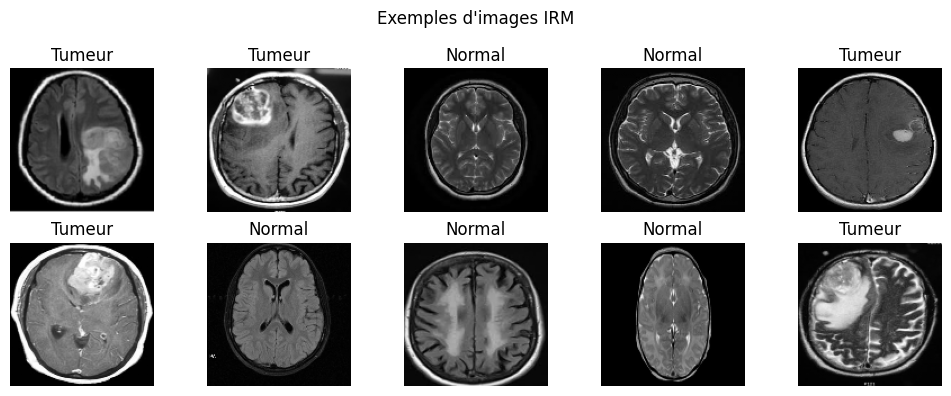

In [6]:
# 1.3 Afficher quelques exemples aléatoires
import matplotlib.pyplot as plt
import random

plt.figure(figsize=(10,4))
for i, idx in enumerate(random.sample(range(len(X)), 10)):
    plt.subplot(2,5,i+1)
    plt.imshow(X[idx], cmap='gray')
    plt.title("Tumeur" if y[idx]==1 else "Normal")
    plt.axis('off')
plt.suptitle("Exemples d'images IRM")
plt.tight_layout()
plt.show()

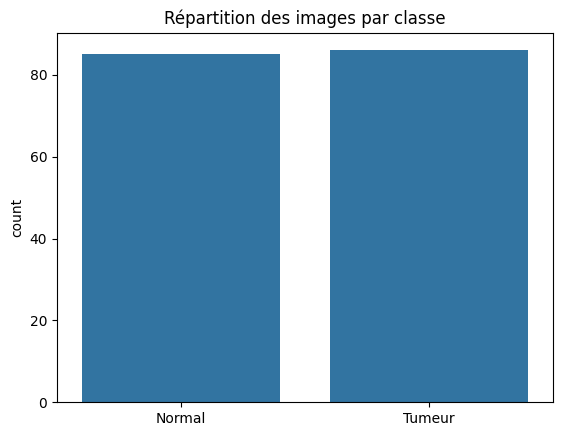

In [7]:
# 1.4 Distribution des classes
import seaborn as sns

sns.countplot(x=y)
plt.xticks([0,1], ['Normal','Tumeur'])
plt.title("Répartition des images par classe")
plt.show()

In [8]:
from sklearn.model_selection import train_test_split

# on reshape X pour ajouter la dimension « canal »
X = X.reshape(-1, 128, 128, 1)

# split 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

print("Train :", X_train.shape, y_train.shape)
print("Test  :", X_test.shape,  y_test.shape)

Train : (136, 128, 128, 1) (136,)
Test  : (35, 128, 128, 1) (35,)


In [9]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,1)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,705,345 (14.13 MB)

 Trainable params: 3,705,345 (14.13 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=16,
    validation_split=0.1  # 10% des données d'entraînement pour val
)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 366ms/step - accuracy: 0.5104 - loss: 177.3544 - val_accuracy: 0.7143 - val_loss: 2.2710
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.5711 - loss: 9.6618 - val_accuracy: 0.6429 - val_loss: 0.7111
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7016 - loss: 0.5688 - val_accuracy: 0.5714 - val_loss: 0.5734
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7483 - loss: 0.5174 - val_accuracy: 0.5714 - val_loss: 0.6339
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8201 - loss: 0.4223 - val_accuracy: 0.5714 - val_loss: 0.5508
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8635 - loss: 0.3172 - val_accuracy: 0.5000 - val_loss: 0.6022
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9278 - loss: 0.2891 - val_accuracy: 0.7143 - val_loss: 0.5517
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9275 - loss: 0.2762 - val_accuracy: 0.7143 - val_loss: 0.47

In [11]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc*100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step - accuracy: 0.8440 - loss: 0.3714
Test Accuracy: 82.86%


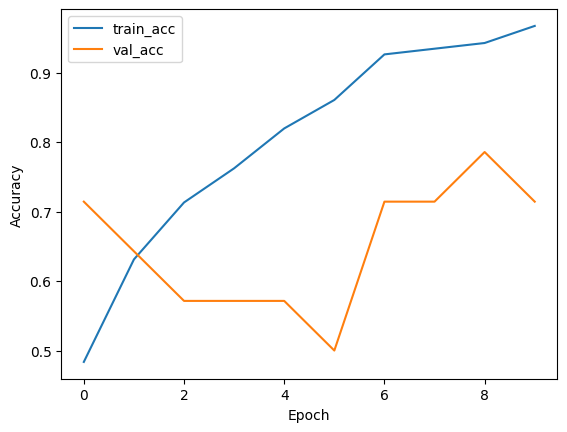

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
# Sauvegarde au format natif
model.save('/content/brain_tumor_model.keras')

In [16]:
#pour recharger plus tard
from tensorflow.keras.models import load_model
model = load_model('/content/brain_tumor_model.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [17]:
#Fonction de prédiction sur fichier
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

def predict_and_show(img_path):
    # Charger et préparer
    img = image.load_img(img_path, color_mode='grayscale', target_size=(128,128))
    arr = image.img_to_array(img)/255.0
    arr = np.expand_dims(arr,0)
    # Prédiction
    p = model.predict(arr)[0][0]
    label = "Tumeur" if p>0.5 else "Normal"
    # Affichage
    plt.imshow(img, cmap='gray')
    plt.title(f"{label} ({p:.2f})")
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


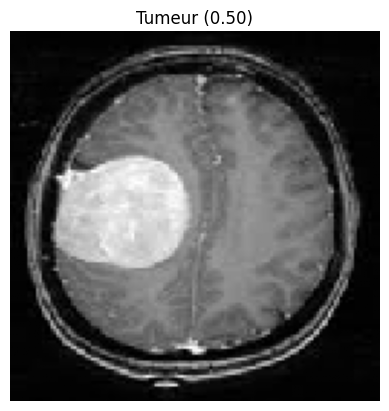

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


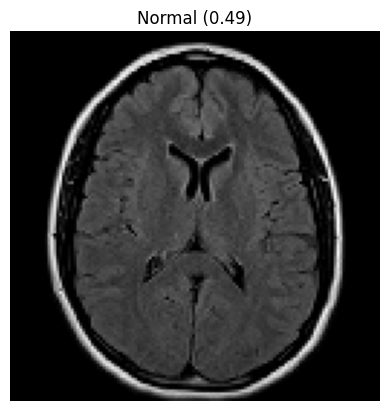

In [18]:
#Teste sur quelques images du dossier yes et no
predict_and_show(yes_paths[0])
predict_and_show(no_paths[0])